Bohao Hu #33131277
Leanne Su #55285753 
Grady Chen #18865568

In [1]:
import time as t
import numpy as np
import math
import matplotlib.pyplot as plt
import flyby_fns as flyby

Text(65, 0, ' Computational time: 7.46e-01.')

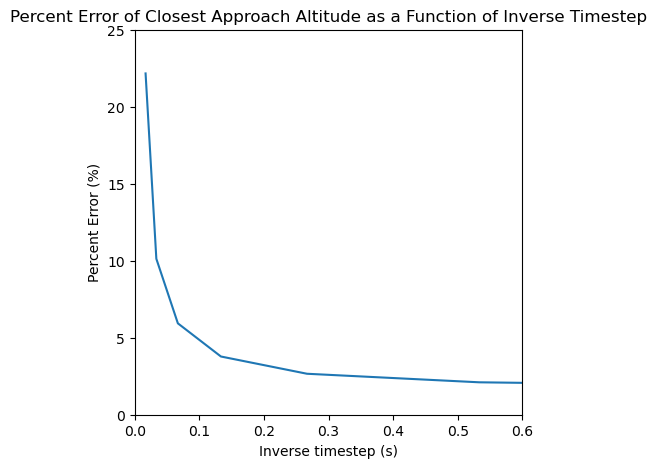

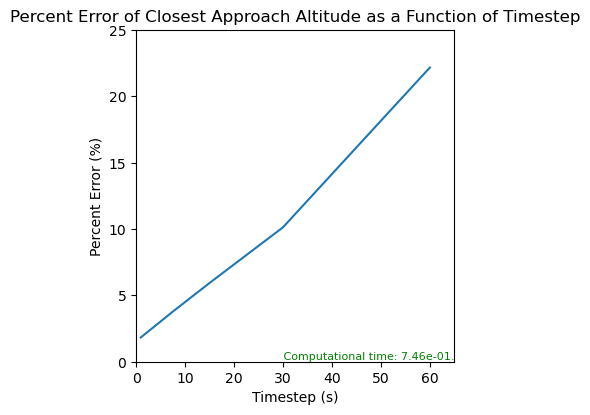

In [2]:
#Initial Values
v_x0 = 0 #(m/s)
v_y0 = 7000 #(m/s)
time_step = 60 #(s)
total_time = 40 * 60 #(s)
planet_mass = 3.3e23 #(kg)
planet_radius = 2440*1000 #(m)
s_x0 = -3050*1000 #(m)
s_y0 = -3*planet_radius #(m)
filename = "./part3C_sx0_CA.txt"

#===============================================================================

with open(filename, "w") as f:
    f.write("s_y0 (Rp)   min alt (km)\n")
    for i in range(10):
            time, acc, vel, pos = flyby.get_traj(s_x0, s_y0, v_x0, v_y0, time_step, total_time, planet_mass, planet_radius)
    
            altitude = np.linalg.norm(pos, axis=1) - planet_radius
            min_alt = np.round(np.min(altitude)) 
            f.write(f'{np.round(s_y0/planet_radius, 1)}km       {np.round(min_alt/1000, 1)}km\n')
            # print(f'{(s_y0/planet_radius)}km, {min_alt/1000}km')
    
            total_time *= 2
            s_y0 *= 2
            
#===============================================================================

s_y0 = -96*planet_radius
total_time = 76800
time_step = 60
target_alt = 195000
errors = []
time_steps = []
math_funnys = []
t_start = t.perf_counter()

time, acc, vel, pos = flyby.get_traj(s_x0, s_y0, v_x0, v_y0, time_step, total_time, planet_mass, planet_radius)
altitude = np.linalg.norm(pos, axis=1) - planet_radius
min_alt = np.round(np.min(altitude))
percent_error = 100 * (min_alt - target_alt)/target_alt

while percent_error > 2:
    time_steps.append(time_step)
    math_funny = 1/time_step
    math_funnys.append(math_funny)
    errors.append((percent_error))
    time_step /= 2
    time, acc, vel, pos = flyby.get_traj(s_x0, s_y0, v_x0, v_y0, time_step, total_time, planet_mass, planet_radius)
    altitude = np.linalg.norm(pos, axis=1) - planet_radius
    min_alt = np.round(np.min(altitude)) 
    percent_error = 100 * (min_alt - target_alt)/target_alt
    

time_steps.append(time_step)
math_funnys.append(1/time_step)
errors.append((percent_error))

t_stop = t.perf_counter()


# print(f'elapsed time: {t_stop - t_start:.2e} seconds.')
# print(percent_error, errors, time_steps, len(math_funnys))

#===============================================================================

fig, ax = plt.subplots(1, 1, figsize = (5, 5))

ax.plot(math_funnys, errors) # I included it cause I didn't see where it said exclude
ax.set_xlim(0, 0.6)
ax.set_ylim(0, 25)
ax.set_xlabel('Inverse timestep (s)')
ax.set_ylabel('Percent Error (%)')
ax.set_title('Percent Error of Closest Approach Altitude as a Function of Inverse Timestep')

fig2, ax2 = plt.subplots(1, 1, figsize = (5,5))
fig2.tight_layout(pad = 5)
ax2.plot(time_steps, errors)
ax2.set_xlim(0, 65)
ax2.set_ylim(0, 25)
ax2.set_xlabel('Timestep (s)')
ax2.set_ylabel('Percent Error (%)')
ax2.set_title("Percent Error of Closest Approach Altitude as a Function of Timestep")
label_text = (f' Computational time: {t_stop - t_start:.2e}.')
ax2.text(65, 0, label_text, ha='right', va='bottom', color='green', fontsize=8)

#===============================================================================

#Use adaptive time stepping - have the time step decrease at the same rate as the position decrease relative to itself,
#so that they maintain the same rate of descent to the minimum altitude.

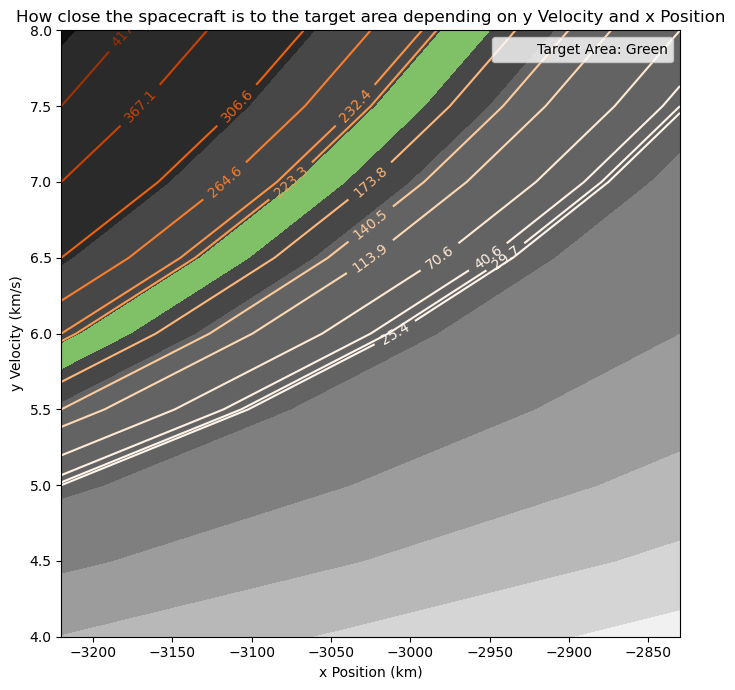

In [3]:
s_y0 = -96*planet_radius
total_time = 1280 * 60 #(s)
time_step = 0.9375
target_alt = 195 * 1000 #(m)
initial_pos = -(planet_radius + (4* target_alt))
last_pos = -(planet_radius + target_alt)

vel_values = np.arange(4000, 8000 + 500, 500)
pos_values = np.arange(initial_pos, last_pos, target_alt)

#===============================================================================

def mag(x, y):
    """
    Calculates the magnitude of two arrays
    
    input = x (array), y (array)
    output = arr (array)
    """
    arr = np.ones(len(x)) * np.nan
    for i in range(len(x)):
        arr[i] = math.sqrt(x[i]**2 + y[i]**2)
    return arr

def find_lowest_altitude(x):
    """
    finds index of smallest number
    
    input: x (array)
    output: np.argmin(x) (int)
    """
    
    return np.argmin(x)

#===============================================================================

lowest_alt_x = np.array([])
lowest_alt_y = np.array([])
lowest_alt = np.zeros((len(vel_values),len(pos_values)))
positive_low_alt = np.array([])

for ii,s_x0 in enumerate(pos_values):
    for jj,v_y0 in enumerate(vel_values):
        time, acc, vel, pos = flyby.get_traj(s_x0, s_y0, v_x0, v_y0, time_step, total_time, planet_mass, planet_radius)
        lowest_alt[jj,ii] = np.min(mag(pos[:, 0]/1000, pos[:, 1]/1000) - planet_radius/1000)
        positive_alt = np.min(mag(pos[:, 0]/1000, pos[:, 1]/1000) - planet_radius/1000)
        if (positive_alt > 0):
            positive_low_alt = np.append(positive_low_alt, positive_alt )
            
            
#===============================================================================

fig, ax = plt.subplots(figsize=(7, 7))

ax.set_facecolor("black")  
CSF = ax.contourf(
    pos_values/1000,vel_values/1000,lowest_alt, cmap = "binary"
)
CS = ax.contour(pos_values/1000,vel_values/1000,lowest_alt, levels = np.sort(positive_low_alt), cmap = "Oranges")
ax.contourf(pos_values/1000,vel_values/1000,lowest_alt,levels=[target_alt/1000 - 5, target_alt/1000 + 25], cmap = "summer")
ax.clabel(CS, inline=True)
ax.legend(["Target Area: Green"])
ax.set_xlabel("x Position (km)")
ax.set_ylabel("y Velocity (km/s)")
ax.set_title("How close the spacecraft is to the target area depending on y Velocity and x Position")
# CB = plt.colorbar(mappable=CSF)

    
plt.tight_layout()


Crash Detected: Initial y velocity 7500 m/s, Initial x Position-2732800.0 m


Text(-2732.8, -9760.0, 'Crash Trajectory Starting from:  \n y velocity 7.5 km/s, \n x Position-2732.8 km ')

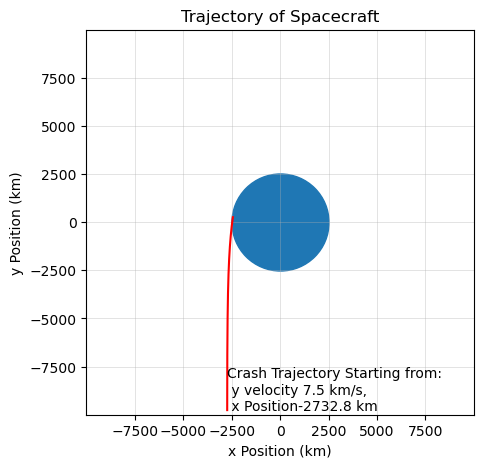

In [4]:
pos_values = np.arange(-planet_radius, -4 * planet_radius, -planet_radius/50)
s_y0 = -4 *planet_radius
# print(pos_values)
break_ = 1
crash_stop_point = np.nan
for s_x0 in pos_values:
    i = 0
    for v_y0 in vel_values:
        i += 1
        time, acc, vel, pos = flyby.get_traj(s_x0, s_y0, v_x0, v_y0, time_step, total_time, planet_mass, planet_radius)
        altitude = mag(pos[:, 0]/1000 + 500, pos[:, 1]/1000) - planet_radius/1000
        # print(i, np.min(altitude))
        if (np.min(altitude) <= 500) & (np.min(altitude) >= -500):
            print(f"Crash Detected: Initial y velocity {v_y0} m/s, Initial x Position{s_x0} m")
            s_x = s_x0
            s_y = s_y0
            v_y = v_y0
            crash_stop_point = find_lowest_altitude(altitude)
            break_ = 0
            break
    if (break_ == 0):
        break
        
#===============================================================================

fig, ax = plt.subplots(figsize = (5, 5))
ax.plot(pos[0 : crash_stop_point , 0]/1000, pos[0 : crash_stop_point , 1]/1000, c = "#ff0000")
ax.set_xlim(-9999, 9999)
ax.set_ylim(-9999, 9999)
ax.set_xlabel("x Position (km)")
ax.set_ylabel("y Position (km)")
ax.set_title("Trajectory of Spacecraft")
ax.grid(True, alpha=0.5, which='both', linewidth=0.5, axis='both')
ax.scatter(0, 0, marker = "o", s = planet_radius/1000 * 2)
ax.annotate(f"Crash Trajectory Starting from:  \n y velocity {v_y0/1000} km/s, \n x Position{s_x0/1000} km ", 
            (s_x/1000, s_y/1000))

